In [1]:
#HACKATHON FINAL
import sys 
import sklearn 
import pandas as pd 
import geopandas as gpd
import os 
import tarfile 
import urllib 
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from itertools import count 

In [ ]:
#load in hurricane data
hur_id_n = pd.read_csv('/Users/christianabys/Desktop/School/Maryland/hackathon/hurricane_index.csv')

In [ ]:
#normalize hurricane data
hur_norm = hur_id.iloc[:, :9]
for col in hur_norm:
    hur_norm[col] = hur_norm[col].map(lambda x: x/hur_norm[col].max())
hur_norm = hur_norm.drop(columns = ['FID'])
hur_norm["FID"] = hur_id['FID']

In [ ]:
#calculate hurricane index 
hur_norm['hurricane_index'] = ((hur_norm['p1'] + hur_norm['p2'] + hur_norm['p3'] + hur_norm['p40'] 
                                + hur_norm['p75'] + hur_norm['p115']) +
                                hur_norm['elevation_risk']) + hur_norm['prop_damage']

In [ ]:
#save as csv for safekeeping
#hur_norm.to_csv('/Users/christianabys/Desktop/School/Maryland/hackathon/hur_norm.csv')

In [2]:
#load in normalized dataset
hur_norm = pd.read_csv('/Users/christianabys/Desktop/School/Maryland/hackathon/hur_norm.csv')

In [3]:
#data processing and import svi data
svi_g = gpd.read_file('/Users/christianabys/Downloads/xn--CDCs_Social_Vulnerability_Index_(SVI)__2014_overall_SVI,_census_tract_level_-_Wake_County-shp-zj43djp/Overall_2014_Tracts.shp')
svi_g = svi_g[["FID", "ST_ABBR", "EP_POV","EP_UNEMP","EP_PCI","EP_NOHSDP","EP_AGE65","EP_AGE17","EP_DISABL",
           "EP_SNGPNT","EP_MINRTY","EP_LIMENG","EP_MUNIT","EP_MOBILE","EP_CROWD",
           "EP_NOVEH","EP_GROUPQ","EP_UNINSUR","RPL_THEMES","geometry"]]
#remove -999 and drop na
svi_g = svi_g[svi_g != -999]
svi_g = svi_g.dropna()

In [4]:
#merge svi with hurricane index
master = pd.merge(svi_g, hur_norm, on = 'FID')
#set as geodataframe and set crs
master = gpd.GeoDataFrame(master, geometry = 'geometry',crs = "EPSG: 4326")
#calculate adj_svi_index
master['adj_svi_index'] = (master['RPL_THEMES'] + master['hurricane_index'])/2

In [47]:
#modeling
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
#run either without hurricane data or with
param = input('Run with hurricane index? (Yes or No): ')
if param == 'Yes':
    i = master[master['hurricane_index'] > 0].drop_duplicates('ST_ABBR')
    m_list = i['ST_ABBR']
    master = master.loc[master['ST_ABBR'].isin(m_list)]
    #master_svi, select only variabes, leave out st_abbr and geometry
    svi_tot = master[["FID", "EP_POV","EP_UNEMP","EP_PCI","EP_NOHSDP","EP_AGE65","EP_AGE17","EP_DISABL",
           "EP_SNGPNT","EP_MINRTY","EP_LIMENG","EP_MUNIT","EP_MOBILE","EP_CROWD",
           "EP_NOVEH","EP_GROUPQ","EP_UNINSUR","RPL_THEMES","adj_svi_index","hurr_index_0_1_adj"]]
    
else:
    svi_tot = master[["FID", "EP_POV","EP_UNEMP","EP_PCI","EP_NOHSDP","EP_AGE65","EP_AGE17","EP_DISABL",
           "EP_SNGPNT","EP_MINRTY","EP_LIMENG","EP_MUNIT","EP_MOBILE","EP_CROWD",
           "EP_NOVEH","EP_GROUPQ","EP_UNINSUR","RPL_THEMES"]]
    

#set fid list
fid = svi_tot["FID"]
svi = svi_tot.iloc[:, 1:]
if param == 'Yes':
    X = svi.drop(columns=["adj_svi_index",'EP_UNINSUR','EP_AGE17','EP_AGE65'])
    y = svi["adj_svi_index"]
else:
    X = svi.drop(columns=["RPL_THEMES",'EP_UNINSUR','EP_AGE17','EP_AGE65'])
    y = svi['RPL_THEMES']
#set interctions
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X1 = interaction.fit_transform(X)
X = pd.DataFrame(X1)


#PERFORMANCE MEASURES OF MODELS-------------------------------------------------
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

X1 = X.drop(columns=[45,42,41,12,9,8,7,59,51,44,43,40,20,11,10,39,24,21,6,66,62,54,52,49,38,37,36,25,
                                          5,3,0,83,32,23,14,90,73,70,65,58,50,48,22,19,86,71,35,31,85,78,18,17,1,72,69,67])
#random forest regressor 
rf = RandomForestRegressor(n_estimators=20,random_state=(42))
model_rf = rf.fit(X1, y)
#run prediction
preds = rf.predict(X1)
regression_results(y, preds)

Run with hurricane index? (Yes or No): Yes
explained_variance:  0.9994
mean_squared_log_error:  0.0
r2:  0.9994
MAE:  0.0049
MSE:  0.0003
RMSE:  0.0175


In [35]:
#uncomment and run in between running models and predicting to get rid of column name
#master = master.drop(columns = ('Adjusted SVI Index (Predicted)'))

In [51]:
#turn to dataframe, add index and make FID column
preds = pd.DataFrame(preds)
fid = pd.DataFrame(fid).reset_index().drop(['index'],axis = 1)
preds_fid = fid.join(preds)
#rename column 
preds_fid = preds_fid.rename(columns = {0:'y_prediction'})
master = pd.merge(master,preds_fid)
master = master.rename(columns = {'y_prediction':'SVI Index (Predicted)'})

Select state via abbreviation i.e. AK = Alaska, NY = New York) or continental (cont) for Continental US)LA
Select a value to map (see examples): (SVI, hurricane_index)SVI Index (Predicted)


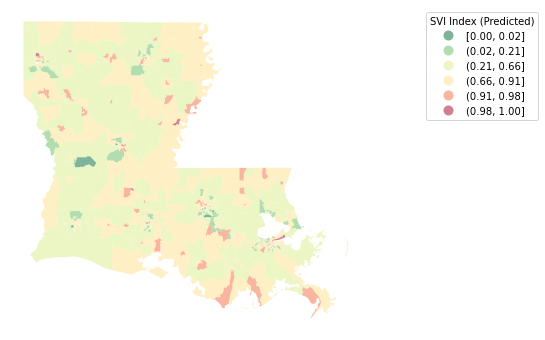

In [40]:
#autographer
cont = master[(master['ST_ABBR']!= 'AK') & (master['ST_ABBR']!= 'HI')]
#select state
st = input('Select state via abbreviation i.e. AK = Alaska, NY = New York) ' \
           'or continental (cont) for Continental US)')

val = input('Select a value to map (see examples): (SVI, hurricane_index)')
if st == 'AK':
    state = master[(master['ST_ABBR']=='AK')]
    #reproject
    state = state.to_crs("EPSG:3338")
elif st == 'HI':
    state =  master[(master['ST_ABBR']=='HI')]
    #reproject
    state = state.to_crs("EPSG:3563")
elif st == 'cont':
    state = master[(master['ST_ABBR']!= 'AK') & (master['ST_ABBR']!= 'HI')]
else:
    state = cont[cont['ST_ABBR']== st]
fig,ax = plt.subplots(figsize=(14, 6))
state.plot(val, scheme = 'Percentiles',ax = ax, alpha = 0.5, 
               k = 10, cmap = 'RdYlGn_r',legend = True)

plt.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5,1))
leg.set_title(val)
plt.savefig('/Users/christianabys/Desktop/School/Maryland/hackathon/plots/SVI_Index_(Predicted)_LA.png')